### Import Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # type: ignore
plt.rcParams['axes.unicode_minus'] = False
import numpy as np # type: ignore
import pandas as pd # type: ignore
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller # type: ignore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # type: ignore
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import statsmodels.api as sm # type: ignore
from factor_analyzer import FactorAnalyzer # type: ignore
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo # type: ignore
from graphviz import Digraph # type: ignore
from scipy.optimize import minimize # type: ignore
from scipy.stats import stats # type: ignore
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from semopy import Model, Optimizer, semplot # type: ignore
import torch # type: ignore
import torch.nn as nn # type: ignore
from torch.utils.data import DataLoader, Dataset # type: ignore
from sklearn.metrics import mean_squared_error, r2_score # type: ignore
from tqdm import tqdm # type: ignore
from argparse import Namespace
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


### Data Directory

In [3]:
feature_path = "../../data/merge_data_V6_eng_V1.csv"
region_feature_path = "../../data/nationwide_eng_V1.csv"

### DFM (Dynamic Factor Model)

In [ ]:
nf = pd.read_csv(region_feature_path).T
nf.columns = nf.iloc[0]
nf = nf.iloc[1:]
for col in nf.columns:
    nf[col] = pd.to_numeric(nf[col], errors='coerce')
nf = nf.dropna()
nf_train, nf_test = train_test_split(nf, test_size=0.2, shuffle=False)

In [1308]:
nf_diff = nf_train.diff().dropna() # nf_diff.shape = (timestemps, features)
optimal_factors = 2

nfm = DynamicFactor(nf_diff, k_factors=optimal_factors, factor_order=1)
nfm_result = nfm.fit(method="powell", maxiter=1000)

shared_component = nfm_result.factors.smoothed.T # (timestemps-1, factors) = (179, 2)
shared_component = np.vstack([shared_component[0], shared_component])
loadings = nfm_result.params.filter(like="loading").values.reshape(nf_train.shape[1], optimal_factors)

shared_component_original = shared_component.cumsum(axis=0)  # (timestemps, factors) = (180, 2)
# 공유 요소를 원래 변수 공간으로 변환
shared_component_final = shared_component_original @ loadings.T  # (timestemps, features) = (180, 17)

# 공유 요소를 원래 데이터의 분포와 맞추기 (스케일 조정)
scale_factor = (nf_train.std() / shared_component_final.std()).values.reshape(1, -1)
shared_component_final = shared_component_final * scale_factor + nf_train.mean().values

# 2017-11-15 기준으로 스케일 조정
reference_date = "2017-11-15"
reference_index = nf_train.index.get_loc(reference_date)
offset = nf_train.iloc[reference_index].values - shared_component_final[reference_index]
shared_component_final = shared_component_final + offset
idiosyncratic_component_final = nf_train - shared_component_final  # (timestemps, features)

/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 18.458637
         Iterations: 17
         Function evaluations: 9882


In [ ]:
nf_test_diff = nf_test.diff().dropna()
# 1. Test 데이터에 대해 공유 요소 구하기
nfm_test_result = nfm_result.apply(nf_test_diff)  # 필터링을 사용하여 새로운 데이터 적용
shared_component_test = nfm_test_result.factors.smoothed.T  # (timestamps_test-1, factors)
shared_component_test = np.vstack(
    [shared_component_original[-1, :], shared_component_test]  # 마지막 공유 요소 값을 초기값으로 사용
)

# 2. Test 공유 요소 적분 (Train의 마지막 값 사용)
shared_component_test_original = shared_component_test.cumsum(axis=0)

# 3. 공유 요소를 원래 변수 공간으로 변환
shared_component_test_final = shared_component_test_original @ loadings.T

# 4. 공유 요소를 원래 데이터의 스케일에 맞추기 (Train의 scale factor 사용)
shared_component_test_final = shared_component_test_final * scale_factor + nf_train.mean().values

# offset_test = nf_test.iloc[reference_index].values - shared_component_test_final[reference_index]
shared_component_test_final = shared_component_test_final + offset

idiosyncratic_component_test_final = nf_test - shared_component_test_final 

In [1310]:
combined_array = np.vstack((shared_component_original, shared_component_test_original))
# pd.DataFrame(combined_array, columns=["factor1","factor2","factor3"]).plot() # 수정

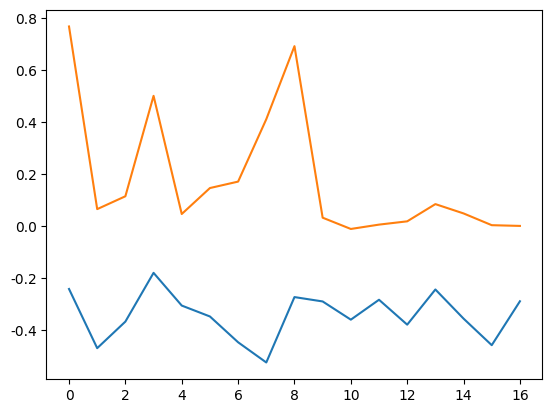

In [1312]:
plt.plot(loadings)

### Load Dataset

In [10]:
interest_rate = ["call_interest_rate", "government_bond_3yr", "deposit_bank_loan_rate_avg"]
stock = ["KOSPI_index", "KOSDAQ_index", "NASDAQ_index"]
money_supply = ["M2_Korea", "M2_USA"]
liquidity = ["broad_liquidity"]
inflation = ["CPI_growth_rate"]
exchange_rate = ["USD_KRW_exchange_rate"]
gdp = ["real_GDP_growth_rate"]
construction = ["residential_building_start_status", "residential_building_permit_status"]
construction_production = ["construction_production_index_seasonally_adjusted"]

column = interest_rate + stock + money_supply + liquidity \
    + inflation + exchange_rate + gdp + \
    construction + construction_production
lag = 3 # 3-month ahead
df = pd.read_csv(feature_path).T
df.columns = df.iloc[0]
df = df.iloc[1:]
df = df.shift(lag) # predict the future by taking past data of explanatory variables
df = df[column].dropna()
# factor_df = pd.DataFrame([])
factor_df= pd.DataFrame(combined_array, columns=["factor1","factor2"], index = nf.index)
df = pd.concat([df,factor_df],axis = 1) 
df = df[18:]
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.loc['2006-01-01':'2024-09-30']

In [14]:
granger_value = {}
def granger_test(data, target, maxlag=12):
    min_p_values = {}
    for col in data.columns:
        if col != target:
            test_result = grangercausalitytests(data[[target, col]], maxlag=maxlag, verbose=False)
            min_p_value = float('inf')
            min_p_lag = 0
            for lag, result in test_result.items():
                p_value = result[0]['ssr_chi2test'][1]  # p-value
                if p_value < min_p_value:
                    min_p_value = p_value
                    min_p_lag = lag
            if min_p_value <= 0.05:
                min_p_values[col] = min_p_lag # round(min_p_value,3))
    granger_value[target] = min_p_values
    print(min_p_values)
    return min_p_values

### VAR

In [1591]:
# t+3 시점의 수준(원래의 값)을 얻으려면 “t+1, t+2, t+3의 예측 차분값의 누적합”을 t 시점의 실제 수준(마지막 관측값)에 더해주어야 한다. 
# 개별 예측마다 마지막 관측값(기준점)이 달라야함. 
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

data_diff = df.diff().dropna()  # 1차 차분
granger_value = granger_test(data_diff, "factor1", maxlag=23)
my_col =list(granger_value.keys()) + ['factor1']

# 1차 차분 (첫 행은 NaN이 되므로 drop)
data_diff = df[my_col].diff().dropna()

# 학습 데이터와 테스트 데이터 분할
train = data_diff[:'2020-12-15']
test = data_diff['2021-01-15':]

forecast_horizon = 3  # 3개월 예측 (t+3)

# 학습 데이터로 VAR 모델 생성 및 피팅
var_model = VAR(train)
selected_lag = 3
var_model_fitted = var_model.fit(selected_lag)

forecasted_levels = []  # 예측한 수준(원시 값)을 저장
forecast_dates = []     # 예측 시점(날짜)을 저장

# 전체 data_diff(차분 데이터)를 대상으로 rolling forecast 수행
# data_diff의 인덱스는 원래 df의 인덱스에서 첫 행을 제외한 것과 같으므로 주의!
for i in range(len(data_diff) - selected_lag):
    # window에 해당하는 데이터를 가져옴 (차분 값)
    window_data = data_diff.iloc[i : i + selected_lag].values
    
    # forecast_horizon 단계 ahead의 차분 예측 (예측 결과 shape: (forecast_horizon, n변수))
    forecast_diff = var_model_fitted.forecast(window_data, steps=forecast_horizon)
    
    # t+3 시점까지의 차분 누적합을 구함.
    # (예: forecast_diff[0] + forecast_diff[1] + forecast_diff[2])
    forecast_diff_cumsum = forecast_diff.cumsum(axis=0)[-1]  # shape: (n변수,)
    
    # **기준(시작) 수준값**: 해당 window의 마지막 관측 시점
    # data_diff는 df.diff().dropna()이므로, data_diff.iloc[k]는 원래 df의 인덱스 k+1에 해당함.
    # window_data는 data_diff.iloc[i : i+selected_lag]이므로 마지막 관측은 data_diff.iloc[i+selected_lag-1],
    # 이에 대응하는 원래 df의 수준값은 df.iloc[i+selected_lag]가 됩니다.
    if i + selected_lag < len(df):
        last_level = df[my_col].iloc[i + selected_lag]
    else:
        # 인덱스 초과 시 해당 예측은 건너뜁니다.
        continue
    
    # t+3 시점의 예측 수준값 = 기준 수준값 + 누적된 예측 차분값
    pred_level = last_level + forecast_diff_cumsum
    
    forecasted_levels.append(pred_level)
    
    # 예측 날짜 지정:
    # window의 마지막 관측은 df의 인덱스 i+selected_lag
    # 따라서 t+3에 해당하는 날짜는 df의 인덱스 i+selected_lag+forecast_horizon에 해당함.
    if i + selected_lag + forecast_horizon < len(df):
        forecast_date = df.index[i + selected_lag + forecast_horizon]
    else:
        # 만약 미래 날짜(예: df에 없는 날짜)를 예측해야 한다면, 마지막 날짜 이후로 일정 간격(예: 1개월 간격)으로 날짜를 생성.
        # (여기서는 간단히 마지막 날짜에 offset을 더하는 예시)
        last_date = pd.to_datetime(df.index[-1])
        # (i + selected_lag + forecast_horizon) - (len(df)-1) 개의 기간 만큼 추가
        offset_periods = (i + selected_lag + forecast_horizon) - (len(df) - 1)
        # 예를 들어, 월별 데이터라면:
        forecast_date = last_date + pd.DateOffset(months=offset_periods)
    
    forecast_dates.append(forecast_date)

forecast_df = pd.DataFrame(forecasted_levels, index=forecast_dates, columns=df[my_col].columns)

factor1_df = pd.concat([df["factor1"]['2006-01-15':'2006-0'+str(forecast_horizon+selected_lag)+'-15'], forecast_df["factor1"]])

{'call_interest_rate': 20, 'government_bond_3yr': 5, 'KOSPI_index': 20, 'NASDAQ_index': 17, 'M2_Korea': 23, 'M2_USA': 22, 'broad_liquidity': 17, 'CPI_growth_rate': 19, 'real_GDP_growth_rate': 16, 'residential_building_permit_status': 10, 'factor2': 12}


/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [1592]:
from statsmodels.tsa.api import VAR
data_diff = df.diff().dropna()  # 1차 차분
granger_value = granger_test(data_diff, "factor2", maxlag=5)
my_col =list(granger_value.keys()) + ['factor2']
# 1차 차분 (첫 행은 NaN이 되므로 drop)
data_diff = df[my_col].diff().dropna()

# 학습 데이터와 테스트 데이터 분할
# train_size = int(len(data_diff) * 0.8)
train = data_diff[:'2020-12-15']
test = data_diff['2021-01-15':]

forecast_horizon = 3  # 3개월 예측 (t+3)


# 학습 데이터로 VAR 모델 생성 및 피팅
var_model = VAR(train)
selected_lag = 3
var_model_fitted = var_model.fit(selected_lag)

forecasted_levels = []  # 예측한 수준(원시 값)을 저장
forecast_dates = []     # 예측 시점(날짜)을 저장

# 전체 data_diff(차분 데이터)를 대상으로 rolling forecast 수행
# data_diff의 인덱스는 원래 df의 인덱스에서 첫 행을 제외한 것과 같으므로 주의!
for i in range(len(data_diff) - selected_lag):
    # window에 해당하는 데이터를 가져옴 (차분 값)
    window_data = data_diff.iloc[i : i + selected_lag].values
    
    # forecast_horizon 단계 ahead의 차분 예측 (예측 결과 shape: (forecast_horizon, n변수))
    forecast_diff = var_model_fitted.forecast(window_data, steps=forecast_horizon)
    
    # t+3 시점까지의 차분 누적합을 구함.
    # (예: forecast_diff[0] + forecast_diff[1] + forecast_diff[2])
    forecast_diff_cumsum = forecast_diff.cumsum(axis=0)[-1]  # shape: (n변수,)
    
    # **기준(시작) 수준값**: 해당 window의 마지막 관측 시점
    # data_diff는 df.diff().dropna()이므로, data_diff.iloc[k]는 원래 df의 인덱스 k+1에 해당함.
    # window_data는 data_diff.iloc[i : i+selected_lag]이므로 마지막 관측은 data_diff.iloc[i+selected_lag-1],
    # 이에 대응하는 원래 df의 수준값은 df.iloc[i+selected_lag]가 됩니다.
    if i + selected_lag < len(df):
        last_level = df[my_col].iloc[i + selected_lag]
    else:
        # 인덱스 초과 시 해당 예측은 건너뜁니다.
        continue
    
    # t+3 시점의 예측 수준값 = 기준 수준값 + 누적된 예측 차분값
    pred_level = last_level + forecast_diff_cumsum
    
    forecasted_levels.append(pred_level)
    
    # 예측 날짜 지정:
    # window의 마지막 관측은 df의 인덱스 i+selected_lag
    # 따라서 t+3에 해당하는 날짜는 df의 인덱스 i+selected_lag+forecast_horizon에 해당함.
    if i + selected_lag + forecast_horizon < len(df):
        forecast_date = df.index[i + selected_lag + forecast_horizon]
    else:
        # 만약 미래 날짜(예: df에 없는 날짜)를 예측해야 한다면, 마지막 날짜 이후로 일정 간격(예: 1개월 간격)으로 날짜를 생성.
        # (여기서는 간단히 마지막 날짜에 offset을 더하는 예시)
        last_date = pd.to_datetime(df.index[-1])
        # (i + selected_lag + forecast_horizon) - (len(df)-1) 개의 기간 만큼 추가
        offset_periods = (i + selected_lag + forecast_horizon) - (len(df) - 1)
        # 예를 들어, 월별 데이터라면:
        forecast_date = last_date + pd.DateOffset(months=offset_periods)
    
    forecast_dates.append(forecast_date)

forecast_df = pd.DataFrame(forecasted_levels, index=forecast_dates, columns=df[my_col].columns)
factor2_df = pd.concat([df["factor2"]['2006-01-15':'2006-0'+str(forecast_horizon+selected_lag)+'-15'], forecast_df["factor2"]])

{'NASDAQ_index': 3, 'factor1': 1}


/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


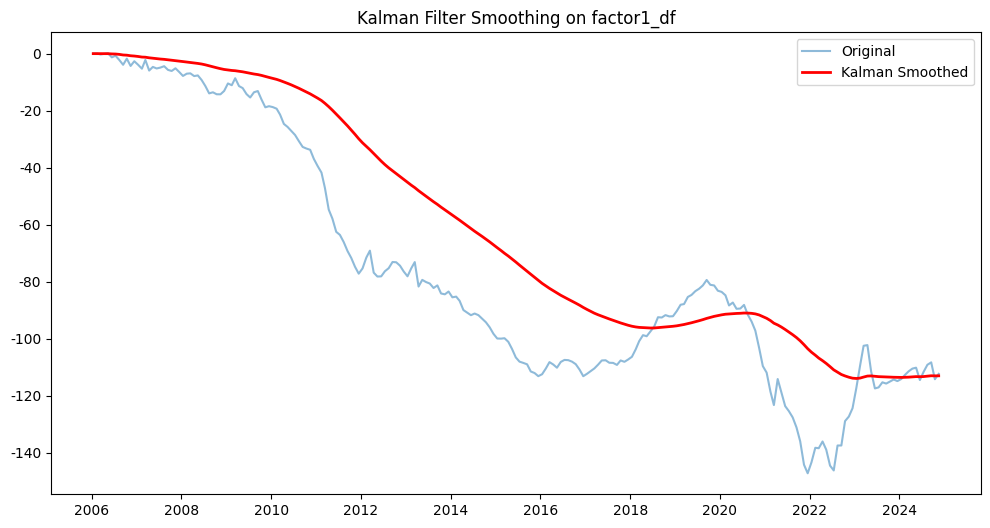

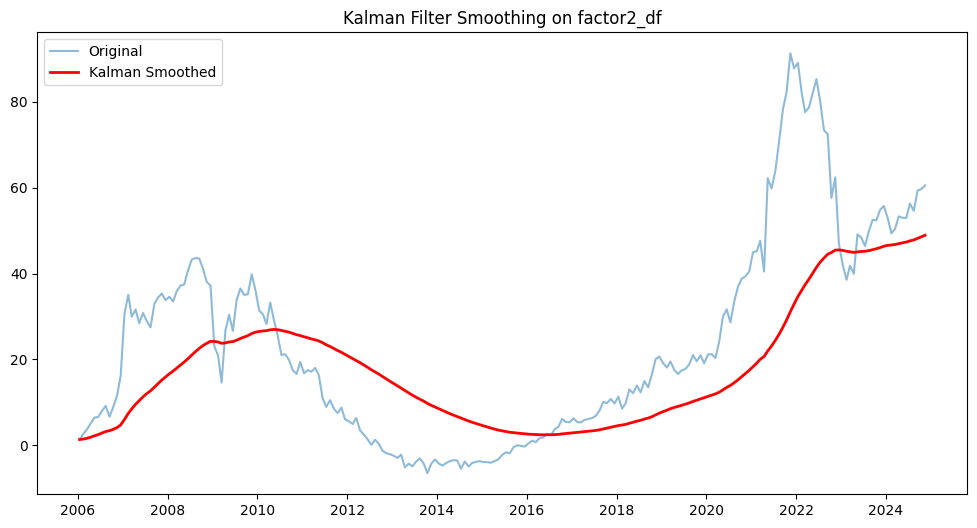

In [1593]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

# Kalman Filter 정의
kf_1 = KalmanFilter(initial_state_mean=factor1_df.iloc[0], 
                  n_dim_obs=1,
                  transition_matrices=[1],  # 상태 전이 행렬 (여기서는 단순 1차 항등 행렬)
                  observation_matrices=[1],  # 관측 행렬 (여기서는 직접 관측)
                  observation_covariance=10,  # 측정 노이즈 (줄이면 더 부드러움)
                  transition_covariance=0.01)  # 상태 전이 노이즈 (줄이면 더 부드러움)

# Kalman Filter 정의
kf_2 = KalmanFilter(initial_state_mean=factor2_df.iloc[0], 
                  n_dim_obs=1,
                  transition_matrices=[1],  # 상태 전이 행렬 (여기서는 단순 1차 항등 행렬)
                  observation_matrices=[1],  # 관측 행렬 (여기서는 직접 관측)
                  observation_covariance=10,  # 측정 노이즈 (줄이면 더 부드러움)
                  transition_covariance=0.01)  # 상태 전이 노이즈 (줄이면 더 부드러움)

# Kalman Filtering 수행
filtered_state_means_1, _ = kf_1.filter(factor1_df.values)
filtered_state_means_2, _ = kf_2.filter(factor2_df.values)

# 결과를 시리즈로 변환
smoothed_factor1 = pd.Series(filtered_state_means_1.flatten(), index=factor1_df.index)
smoothed_factor2 = pd.Series(filtered_state_means_2.flatten(), index=factor2_df.index)
# 원본 데이터와 Kalman Filter 스무딩 결과 비교
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(factor1_df.index),factor1_df, label="Original", alpha=0.5)
plt.plot(pd.to_datetime(factor1_df.index),smoothed_factor1, label="Kalman Smoothed", linewidth=2, color='red')
plt.legend()
plt.title("Kalman Filter Smoothing on factor1_df")
plt.show()
# 원본 데이터와 Kalman Filter 스무딩 결과 비교
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(factor2_df.index),factor2_df, label="Original", alpha=0.5)
plt.plot(pd.to_datetime(factor1_df.index),smoothed_factor2, label="Kalman Smoothed", linewidth=2, color='red')
plt.legend()
plt.title("Kalman Filter Smoothing on factor2_df")
plt.show()


In [1650]:
# Dynamic Factor Model 결과
resid = nf - (pd.concat([factor1_df,factor2_df],axis=1)[:'2024-09-15'].values @ loadings.T \
    * scale_factor + nf_train.mean().values + offset)
resid

Date,Seoul_apartment_sale_price_index,Busan_apartment_sale_price_index,Daegu_apartment_sale_price_index,Incheon_apartment_sale_price_index,Gwangju_apartment_sale_price_index,Daejeon_apartment_sale_price_index,Ulsan_apartment_sale_price_index,Sejong_apartment_sale_price_index,Gyeonggi_apartment_sale_price_index,Gangwon_apartment_sale_price_index,Chungbuk_apartment_sale_price_index,Chungnam_apartment_sale_price_index,Jeonbuk_apartment_sale_price_index,Jeonnam_apartment_sale_price_index,Gyeongbuk_apartment_sale_price_index,Gyeongnam_apartment_sale_price_index,Jeju_apartment_sale_price_index
2006-01-15,4.837381,12.261473,16.985147,-23.686001,2.033552,14.404343,0.932446,41.230497,-11.388926,-12.408129,1.887644,-3.364032,-4.900508,-21.439661,2.281750,12.856131,-13.375789
2006-02-15,4.335323,12.087351,16.800080,-23.565310,1.468946,14.016145,0.614911,41.953106,-11.084659,-12.132611,3.124500,-2.856809,-4.401466,-21.848855,1.740563,12.381791,-14.148752
2006-03-15,4.536969,11.388813,16.349108,-23.486022,1.137312,12.920932,1.453463,46.273908,-10.814308,-13.062319,3.408934,-2.236917,-4.148369,-21.541019,1.672717,13.005089,-15.916372
2006-04-15,3.720534,11.104950,16.336375,-23.267433,0.940289,12.082353,2.001127,41.160869,-10.510037,-12.444922,4.403340,-2.896124,-3.792663,-21.713323,1.782444,12.608157,-15.714977
2006-05-15,2.407478,10.700096,15.806822,-23.048344,0.427550,11.332238,2.833631,41.232876,-10.205752,-11.637264,3.984360,-4.863139,-3.450135,-20.294204,1.780329,12.893220,-15.130877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-15,8.531077,-2.809364,-9.617167,5.311973,18.001803,31.744955,-11.737346,2.973727,15.861849,8.647425,6.793302,3.070427,6.087084,0.163241,-5.075204,-7.144571,3.748625
2024-06-15,9.725741,-5.330372,-12.177260,5.762041,15.527680,29.516769,-13.438923,1.638771,16.105067,6.943895,6.128961,1.739752,4.799502,-0.808231,-5.652874,-9.379056,4.801245
2024-07-15,10.400690,-3.687824,-11.236633,5.803783,16.692222,30.757033,-12.978040,2.668024,16.283853,8.130209,7.592950,2.935942,5.483267,0.046107,-4.938090,-7.588936,5.740702
2024-08-15,15.829689,-1.533825,-10.054412,7.647894,18.149303,31.967526,-11.048277,5.618798,18.900859,9.177402,8.475726,3.180064,7.528547,0.283302,-3.306374,-6.852712,6.923358


In [1642]:
# Dynamic Factor Model 결과
resid = nf - (pd.concat([smoothed_factor1, smoothed_factor2],axis=1)[:'2024-09-15'].values @ loadings.T \
    * scale_factor + nf_train.mean().values + offset)
resid


Date,Seoul_apartment_sale_price_index,Busan_apartment_sale_price_index,Daegu_apartment_sale_price_index,Incheon_apartment_sale_price_index,Gwangju_apartment_sale_price_index,Daejeon_apartment_sale_price_index,Ulsan_apartment_sale_price_index,Sejong_apartment_sale_price_index,Gyeonggi_apartment_sale_price_index,Gangwon_apartment_sale_price_index,Chungbuk_apartment_sale_price_index,Chungnam_apartment_sale_price_index,Jeonbuk_apartment_sale_price_index,Jeonnam_apartment_sale_price_index,Gyeongbuk_apartment_sale_price_index,Gyeongnam_apartment_sale_price_index,Jeju_apartment_sale_price_index
2006-01-15,4.837381,12.261473,16.985147,-23.686001,2.033552,14.404343,0.932446,41.230497,-11.388926,-12.408129,1.887644,-3.364032,-4.900508,-21.439661,2.281750,12.856131,-13.375789
2006-02-15,5.710949,12.155234,16.969570,-23.126346,1.528114,14.188502,0.814135,42.481896,-10.539071,-12.110190,3.090747,-2.863424,-4.400589,-21.748852,1.778283,12.358290,-14.173513
2006-03-15,7.001074,11.726475,16.828720,-22.693820,1.405290,13.351804,1.970129,47.387084,-9.823464,-12.922130,3.484325,-2.169192,-4.012188,-21.271784,1.862148,13.146266,-15.784726
2006-04-15,7.407968,11.402799,16.885102,-22.087602,1.185777,12.609872,2.620867,42.667338,-9.040291,-12.331172,4.385725,-2.871175,-3.718114,-21.396933,1.948916,12.643460,-15.686953
2006-05-15,7.246787,10.981776,16.437995,-21.502943,0.667842,11.962810,3.566193,43.126042,-8.283740,-11.538540,3.892576,-4.870617,-3.420338,-19.924524,1.937207,12.846916,-15.183059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-15,14.128883,-4.204988,-10.289404,7.052564,16.989119,31.501281,-12.163160,3.841261,17.977129,7.964683,5.604751,2.427796,5.049078,-0.127020,-5.864665,-8.658318,2.286027
2024-06-15,16.607786,-4.143130,-10.638828,7.981267,16.459193,30.858185,-11.815321,4.935352,18.887731,7.448473,6.493054,2.018830,5.331971,0.045550,-4.986087,-8.777640,5.367825
2024-07-15,19.805635,-3.935183,-10.657436,8.785475,16.563333,31.533248,-12.142174,5.736764,19.969329,7.954130,6.914839,2.628701,5.046019,0.433117,-5.081480,-8.353090,4.991882
2024-08-15,22.200947,-3.376000,-11.026215,9.622052,16.806474,31.546766,-11.720576,6.411303,21.292493,8.282868,6.963425,2.355201,6.189052,-0.152870,-4.348015,-8.790825,5.052002


In [ ]:
date = 'Date'
resid = resid.reset_index(names=date) 
resid[date] = pd.to_datetime(resid[date]) 

resid.reset_index(drop=True, inplace=True)
resid.index.name = "num"

resid


### Deep Learning Model

In [1564]:
def standardization(train_df, test_df, not_col, target): 
    train_df_ = train_df.copy()
    test_df_ = test_df.copy()
    col =  [col for col in list(train_df.columns) if col not in [not_col]]
    mean_dict = {}
    std_dict = {}
    
    for x in col:
        mean, std = train_df_.agg(["mean", "std"]).loc[:,x]
        train_df_.loc[:, x] = (train_df_[x] - mean) / std
        test_df_.loc[:, x] = (test_df_[x] - mean) / std
        if x in target:
            mean_dict[x] = mean
            std_dict[x] = std
    return train_df_, test_df_, mean_dict, std_dict

def time_slide_df(df, window_size, forecast_size, date, target):
    df_ = df.copy()
    data_list = []
    dap_list = []
    date_list = []
    for idx in range(0, df_.shape[0] - window_size - forecast_size + 1):
        # x: features from the past window_size (including columns)
        x = df_.loc[idx:idx+window_size-1, target].values 
        # get target value for future forecast size 
        y = df_.loc[idx+window_size:idx+window_size+forecast_size-1, target].values
        # get date value for future forecast size 
        date_ = df_.loc[idx+window_size:idx+window_size+forecast_size-1, date].values
        
        data_list.append(x)
        dap_list.append(y)
        date_list.append(date_)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32'), np.array(date_list)

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        # return self.X[idx], self.Y[idx]
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x,y

In [1645]:
# from HeavyBallNODE import Model
# from MLP import Model
# from xPatch import xPatch
from MLPpatch import Model
# from MLPlatent import Model
# from MLPpatchLatent import Model
# from neww import Model

In [1566]:
# Model = xPatch

In [1639]:
# resid = pd.concat([idiosyncratic_component_final, idiosyncratic_component_test_final])
# date = 'Date'
# resid = resid.reset_index(names=date) 
# resid[date] = pd.to_datetime(resid[date])
# resid.reset_index(drop=True, inplace=True)
# # resid

In [1647]:
window_size = 3
forecast_size= 3 

train_df = resid[0:180+forecast_size+window_size-1]
test_df = resid[180:] # 2021-01-15 ~ 
test_df.reset_index(drop=True, inplace=True)
test_df.index.name = "num"

version = "VAR_V2"
batch_size = 16
epoch_ = 1000
lr = 0.001
patience = 20  # easrly stopping

columns_to_use = resid.columns[1:]

# configs = Namespace( # Convert configs dictionary to Namespace
#     seq_len = window_size,
#     pred_len = forecast_size,
#     enc_in = len(columns_to_use), # feature_size
#     # hidden_dim = 5, 
#     use_patch = True,
#     patch_len = 3,
#     ma_type = 'ema',
#     alpha = 0.3,
#     beta = 0.3,
# )

configs = Namespace( # Convert configs dictionary to Namespace
    seq_len=max(window_size, 1),  # Set minimum input length to 1
    pred_len=forecast_size,
    ker_len=25,  # 25
    enc_in= len(columns_to_use), # feature_size
    patch_len = 3,
    stride = 2,
    padding_patch = 'end',
    revin = True,
    ma_type = 'ema',
    alpha = 0.3,
    beta = 0.3,
    use_patch=True,
    patch_size = 3,
)

# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
    
train_x, train_y, train_date = time_slide_df(train_df_fe, window_size, forecast_size, date, columns_to_use)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forecast_size, date, columns_to_use)
    
# Prepare DataLoader 
train_ds = Data(train_x, train_y)
test_ds = Data(test_x, test_y)
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

  8%|▊         | 78/1000 [00:05<01:08, 13.48it/s]


Early stopping triggered.


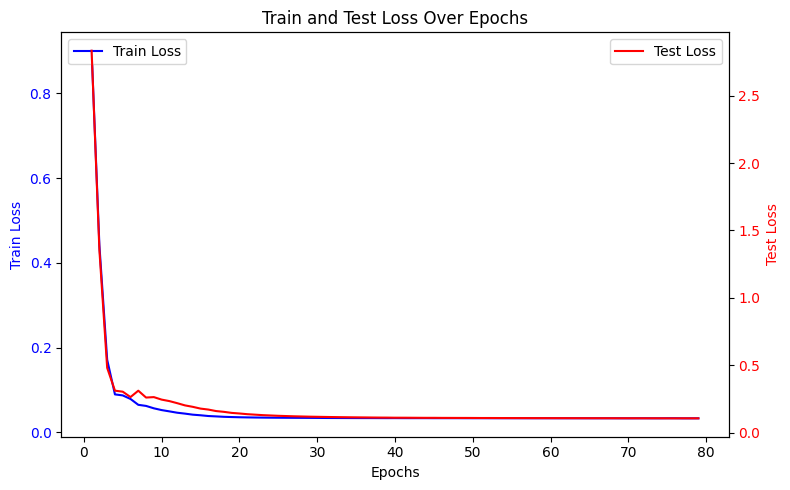

In [1648]:
for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    model.eval()
    with torch.no_grad():
        test_loss_list_epoch = []
        for data, target in test_dl:
            output = model(data)
            test_loss = criterion(output, target)
            test_loss_list_epoch.append(test_loss.item())
            
        test_loss = np.mean(test_loss_list_epoch)
        test_loss_list.append(test_loss)

    if train_loss < max_loss:
        torch.save(model.state_dict(), f"./model{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = train_loss
        dlinear_best_test_loss = test_loss
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
fig, ax1 = plt.subplots(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
ax1.plot(epochs, train_loss_list, label='Train Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Train Loss",color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc="upper left")
# ax1.grid()
ax2 = ax1.twinx()
ax2.plot(epochs, test_loss_list, label='Test Loss',color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel("Test Loss",color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc="upper right") 
# ax2.grid()
plt.title('Train and Test Loss Over Epochs')
fig.tight_layout()
plt.show()
    

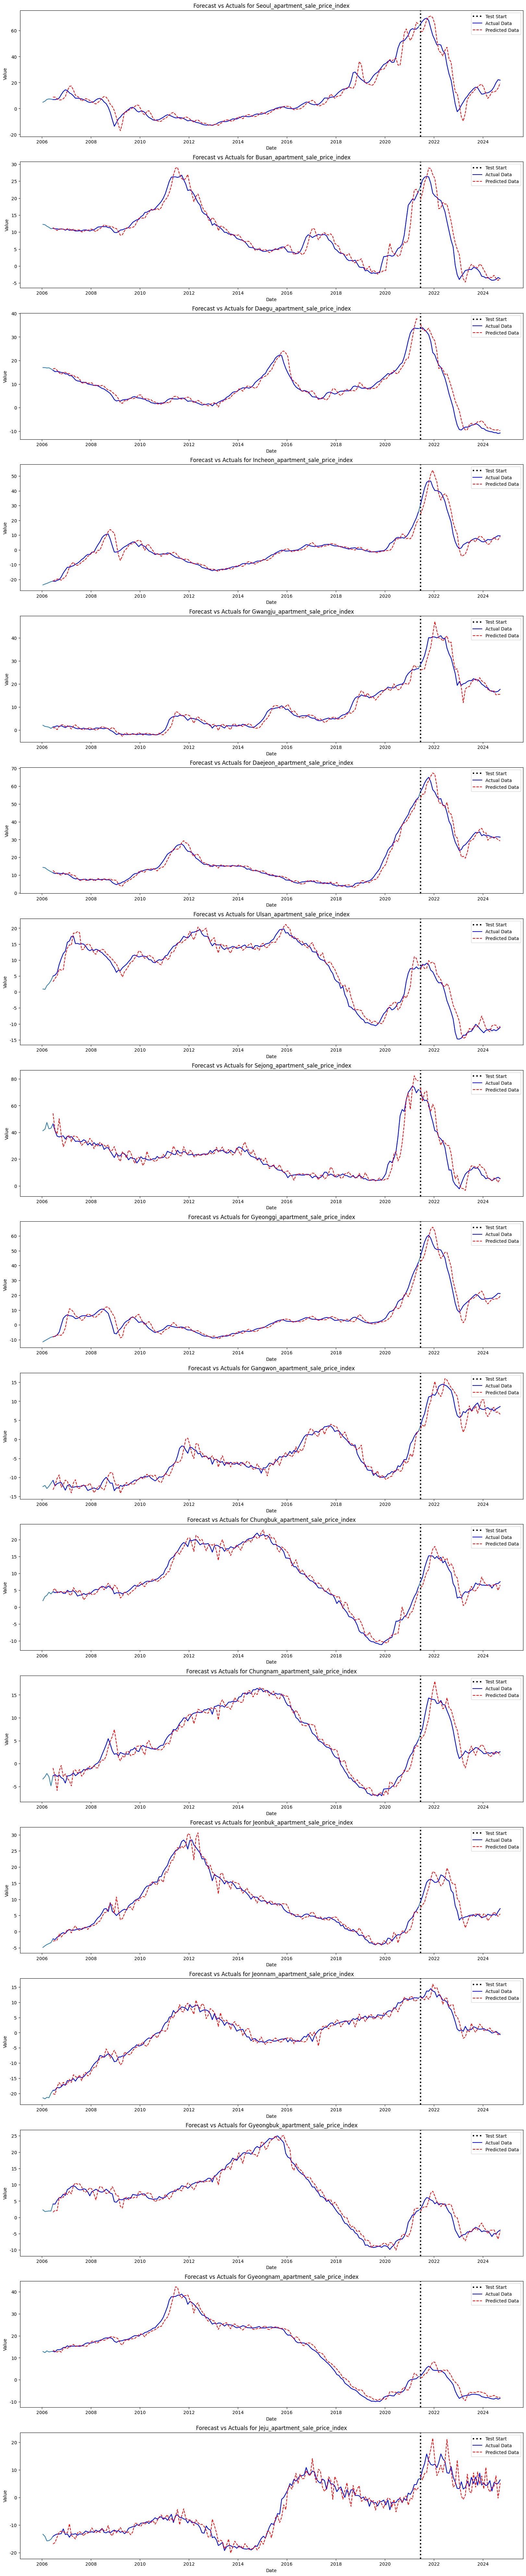

In [1649]:
model.load_state_dict(torch.load(f"./model{version}.pth"))  # 최적 모델 로드
model.eval()

train_dl  = DataLoader(train_ds,  batch_size = len(train_df), shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)
with torch.no_grad():
    for data, target in train_dl:
        train_output = model(data)
        train_predicted = train_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        train_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        train_dates = train_date[:, -1]                    # Dates corresponding to the last forecast
    
    for data, target in test_dl:
        test_output = model(data)
        test_predicted = test_output[:, -1, :].cpu().numpy()  # Last timestep predictions
        test_actual = target[:, -1, :].cpu().numpy()     # Last timestep actual values
        test_dates = test_date[:, -1]  


    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    mask = ~np.isnan(real) & ~np.isnan(pred)
    real_clean = real[mask]
    pred_clean = pred[mask]

    # 정제된 데이터로 RMSE와 R2 계산
    rmse = mean_squared_error(real_clean, pred_clean)**0.5
    r2 = r2_score(real_clean, pred_clean)

    val = [columns_to_use[i], rmse, r2]
    pd.DataFrame(val).T.to_csv(f"./result{version}.csv", mode='a', header=False, index=False)
    
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(resid['Date'], resid[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()       